# Predictive models

This notebook includes many different approaches to predictive models.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.append('../src/')
import aposch_functions as aposch
import predictive_model_helpers as pmh

In [3]:
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

from predictive_model_helpers import PersistenceRegressor

#### Get datasets

In [4]:
# read in data
data2019 = pd.read_csv('../data/2019_RAW_APC_Data.csv.gz')

# get df04
df04 = aposch.clean_data(data2019)

# split into test/train sets
df04_train, df04_test = train_test_split(df04,
                                         test_size=0.2,
                                         random_state=19)

# get cycle-related features
df05_train = aposch.do_cycles_processing(df04_train)

### Create datasets with X in the format for "predict next"

Need to think about this.

Goal: use previous passenger counts to predict the current passenger count.

Q: Should I train one model using all stadirs at once? Or, should I train a different model for each stadir?

Q: What is the time granularity?
- Q: What is the best time granularity that I even have?
  - For a given stadir, look at what kind of granularity/resolution do we have?
  - For a given stadir, how many observations do we have *per hour*?

In [5]:
# For a given stadir, how many observations do we have *per hour*?
# Ans: we have an average of 5 per hour
agg = df04.groupby(['stadir_ID','DOY','Hour'])['passwithin'].count()
agg.median()

5.0

For a first trial, focus only on Pioneer Square going Southbound. Use only the observations of passwithin of other trains that passed through in the short time before the train of interest arrives.

Pioneer Southbound is stadir_ID 1211.

In [6]:
pioneer = df04.loc[df04['stadir_ID']==1211,
       ['railcar ID','DOY','stop arrival time','passwithin']].sort_values('stop arrival time')

In [7]:
pioneer_ts = pioneer.set_index('stop arrival time', drop=True)['passwithin']

Get all the features we need:

In [8]:
pioneer = pmh.get_features_10x15min(pioneer, pioneer_ts)

did 3000 rows so far
did 6000 rows so far
did 9000 rows so far
did 12000 rows so far
did 15000 rows so far
did 18000 rows so far
did 21000 rows so far
did 24000 rows so far
did 27000 rows so far
did 30000 rows so far
did 33000 rows so far
did 36000 rows so far


In [9]:
pioneer.shape

(37259, 14)

In [10]:
X, y = pioneer.loc[:,'FMP_0':'FMP_9'], pioneer.loc[:,'passwithin']
tridx = X.index.intersection(df04_train.index)
X_train, y_train = X.loc[tridx,:], y[tridx]

In [11]:
X.isna().sum(axis=0) / X.count(axis=0)

FMP_0    0.445156
FMP_1    0.419986
FMP_2    0.222087
FMP_3    0.435081
FMP_4    0.357885
FMP_5    0.425636
FMP_6    0.324764
FMP_7    0.392287
FMP_8    0.306417
FMP_9    0.505840
dtype: float64

In [12]:
X_train.shape

(29819, 10)

Need to get rid of rows that have a lot of NaNs.

Note: we shouldn't be allowed to linearly interpolate using the FMP_8 or FMP_9 - that info wouldn't be available to use in an app situation.

In [13]:
print('Before linear interpolation, X_train had this many NaNs:')
print(X_train.isna().sum())
# interpolate for any NaN chains up to 4 NaNs wide.
X_train2 = X_train.loc[:,'FMP_0':'FMP_7'].interpolate(axis=1, method='linear',
                                limit=4, limit_direction='both', limit_area='inside')
# extrapolate 2 NaNs with nearest obs
X_train3 = X_train2.interpolate(axis=1, method='linear',
                                limit=2, limit_direction='both', limit_area='outside')


print('After linear interpolation, X_train2 had this many NaNs:')
print(X_train2.isna().sum())

print('After slight extrapolation, X_train3 had this many NaNs:')
print(X_train3.isna().sum())

# remove observations that still have NaNs
obs_w_na = X_train3.isna().sum(axis=1) > 0
print('Note that this many observations still have NaNs in X_train3:', sum(obs_w_na))
X_train4 = X_train3.loc[~obs_w_na,:]
print('X_train4 has', len(X_train4), 'observations. This is our primary training set.')

# add back FMP 8 and 9 features
X_train6 = X_train3.copy()
X_train6['FMP_8'] = X_train['FMP_8']
X_train6['FMP_9'] = X_train['FMP_9']


# X_train7 (specifically its last column) is used for the "most recent obs" prediction
X_train7 = X_train6.fillna(axis=1, method='ffill')

# use this X_train8 for the dummy clasifier (has the correct number of rows)
X_train8 = X_train7.loc[~obs_w_na,:]

# a couple more special-case inputs for our persistence regressor
X_train9 = np.array(X_train8.loc[:,'FMP_9']).reshape(-1,1)
X_train10 = np.array(X_train8.loc[:,'FMP_7']).reshape(-1,1)

# these are our thrown out targets
y_train_out = y_train[obs_w_na]

# these are our targets we will use
y_train2 = y_train[~obs_w_na]



Before linear interpolation, X_train had this many NaNs:
FMP_0     9163
FMP_1     8844
FMP_2     5481
FMP_3     9118
FMP_4     7850
FMP_5     8917
FMP_6     7290
FMP_7     8382
FMP_8     6970
FMP_9    10037
dtype: int64
After linear interpolation, X_train2 had this many NaNs:
FMP_0    9163
FMP_1    4041
FMP_2    2346
FMP_3    2057
FMP_4    1813
FMP_5    1849
FMP_6    2623
FMP_7    8382
dtype: int64
After slight extrapolation, X_train3 had this many NaNs:
FMP_0    2310
FMP_1    1932
FMP_2    1602
FMP_3    1321
FMP_4    1006
FMP_5     850
FMP_6     936
FMP_7    1265
dtype: int64
Note that this many observations still have NaNs in X_train3: 2821
X_train4 has 26998 observations. This is our primary training set.


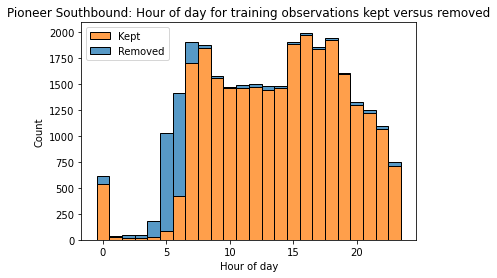

In [14]:
# look into the observations that were kept in:
# Do a hist using stop arrival time
arrival_times = pioneer.loc[tridx,'stop arrival time']

sns.histplot(x=arrival_times.dt.hour, discrete=True, hue=~obs_w_na, multiple='stack',
             hue_order=[0,1])
plt.title('Pioneer Southbound: Hour of day for training observations kept versus removed')
plt.xlabel('Hour of day')
new_l=['Kept','Removed']
plt.legend(labels=new_l)
plt.savefig('../images/PM_kept_thrown_obs.png', bbox_inches='tight')

Note that we kept 26998/29819 = 91% of observations. Great.

In [15]:
print('Check on the ones we threw out:')
print('They had mean', y_train_out.mean(), 'and',
      sum(y_train_out > 74), 'or', sum(y_train_out > 74)/len(y_train_out) ,'were Crowded >74.')

Check on the ones we threw out:
They had mean 23.588089330024815 and 109 or 0.038638780574264446 were Crowded >74.


## Running the predictive models

Recall: use X_train4 for most models, X_train9 and X_train10 for persistence, and y_train2.

In [16]:
scores_dict = {}
cm_dict = {}
models_dict = {}

In [17]:
def run_print_save(name,
                 estimator,
                 X, y):
    print('---', name, '---')
    models_dict[name] = estimator

    cm, sc = pmh.cv_readout_r_to_c(models_dict[name],
                                            X,
                                            y)

    cm_dict[name] = cm
    scores_dict[name] = sc

In [18]:
run_print_save('pers_00m',
             PersistenceRegressor(),
             X_train9,
             y_train2)

--- pers_00m ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19190  1876]
 [ 1788  4144]]
                mean       std
precision   0.687307  0.012336
recall      0.698915  0.015981
f1          0.692958  0.011469
rmse       27.384139  1.931778


In [19]:
run_print_save('pers_30m',
             PersistenceRegressor(),
             X_train10,
             y_train2)

--- pers_30m ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[18990  2076]
 [ 2021  3911]]
               mean       std
precision   0.65123  0.022355
recall     0.658555  0.012232
f1         0.654802  0.016768
rmse       29.50211  1.799824


In [20]:
run_print_save('linreg_8f',
             LinearRegression(),
             X_train4,
             y_train2)

--- linreg_8f ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19561  1505]
 [ 2279  3653]]
                mean       std
precision   0.706195  0.016539
recall      0.615102  0.017651
f1          0.657339  0.013765
rmse       26.769431   1.55269


In [21]:
run_print_save('forest_8f',
             RandomForestRegressor(n_estimators=200, random_state=19),
             X_train4,
             y_train2)

--- forest_8f ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19514  1552]
 [ 1879  4053]]
                mean       std
precision   0.721964  0.013196
recall      0.684662   0.01364
f1           0.70259  0.004466
rmse       25.177766  1.285401


In [22]:
run_print_save('extrees_8f',
             ExtraTreesRegressor(n_estimators=200, random_state=19),
             X_train4,
             y_train2)

--- extrees_8f ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19509  1557]
 [ 1826  4106]]
                mean       std
precision   0.724015  0.015064
recall      0.693396  0.013634
f1          0.708186  0.008481
rmse       25.001882  1.248797


In [23]:
run_print_save('knn_8f',
             KNeighborsRegressor(n_neighbors=100),
             X_train4,
             y_train2)

--- knn_8f ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19618  1448]
 [ 1898  4034]]
                mean       std
precision   0.734045  0.017722
recall      0.681117  0.014463
f1          0.706386  0.010664
rmse       24.799132  1.337654


In [24]:
run_print_save('linreg_4f',
             LinearRegression(),
             X_train4.loc[:,'FMP_4':'FMP_7'],
             y_train2)

--- linreg_4f ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19488  1578]
 [ 2321  3611]]
                mean       std
precision   0.694006  0.014614
recall      0.607897  0.015724
f1          0.648002  0.012957
rmse       26.979719   1.56325


In [25]:
run_print_save('forest_4f',
             RandomForestRegressor(n_estimators=200, random_state=19),
             X_train4.loc[:,'FMP_4':'FMP_7'],
             y_train2)

--- forest_4f ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19231  1835]
 [ 2051  3881]]
                mean       std
precision   0.677811  0.014899
recall      0.654564  0.007692
f1          0.665891  0.008618
rmse       27.263197  1.607631


In [26]:
run_print_save('extrees_4f',
             ExtraTreesRegressor(n_estimators=200, random_state=19),
             X_train4.loc[:,'FMP_4':'FMP_7'],
             y_train2)

--- extrees_4f ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19195  1871]
 [ 2051  3881]]
               mean       std
precision  0.673116  0.017058
recall     0.654908  0.008983
f1         0.663733  0.008916
rmse       27.43838  1.489756


In [27]:
run_print_save('knn_4f',
             KNeighborsRegressor(n_neighbors=100),
             X_train4.loc[:,'FMP_4':'FMP_7'],
             y_train2)

--- knn_4f ---
Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[19368  1698]
 [ 2069  3863]]
                mean       std
precision   0.692853  0.016238
recall      0.651538  0.006679
f1          0.671445  0.008264
rmse       26.189868  1.554752


### Plots

Create datasets for plot and write to .csv:

In [28]:
for statistic in ['precision','recall','f1','rmse']:

    stats = pd.DataFrame(index=scores_dict.keys())

    for model_name in scores_dict.keys():

        row = scores_dict[model_name].loc[statistic]
        stats.loc[model_name,'mean'] = row['mean']
        stats.loc[model_name,'std'] = row['std']

    stats = stats.reset_index()
    stats.to_csv('../data/'+statistic+'.csv', index=False)

Create plots:

In [29]:
for statistic in ['precision','recall','f1','rmse']:

    df = pd.read_csv('../data/'+statistic+'.csv')

    sns.set_theme(style='whitegrid')
    sns.barplot(data=df,x='index',y='mean',
                linewidth=0,
                color=(0.8,0.85,1))
    plt.errorbar(x=df['index'],y=df['mean'], linewidth=3,
                yerr=df['std'], fmt='none', color=(0,0,0))
    plt.xticks(rotation=45)
    plt.title(statistic.capitalize()+' from 5-fold cross-validation. (Errorbar radius is one standard error.)')
    plt.xlabel('Model name')
    plt.ylabel(statistic.capitalize()+' (mean of 5 folds)')

    plt.savefig('../images/'+statistic+'.png', bbox_inches='tight')
    plt.close()

Test different values of k for KNN validation curve:

In [30]:
param_range = [5,25,50,75,100,125,150,175,200]

In [31]:
train_scores, test_scores = validation_curve(
    KNeighborsRegressor(),
    X_train4,
    y_train2,
    param_name='n_neighbors',
    param_range=param_range,
    scoring='neg_root_mean_squared_error',
    n_jobs=2,
)

In [32]:
np.savetxt('../data/KNN_CV_train_scores.csv', train_scores, delimiter=',')
np.savetxt('../data/KNN_CV_test_scores.csv', test_scores, delimiter=',')

In [33]:
train_scores = np.array(pd.read_csv('../data/KNN_CV_train_scores.csv',header=None))
test_scores = np.array(pd.read_csv('../data/KNN_CV_test_scores.csv',header=None))

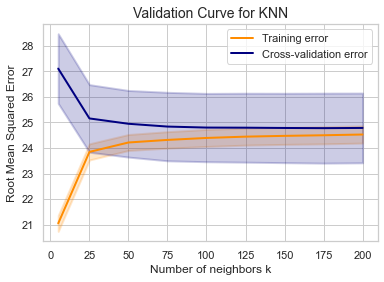

In [34]:
train_scores_mean = np.mean(0-train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(0-test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve for KNN',size=14)
plt.xlabel('Number of neighbors k')
plt.ylabel('Root Mean Squared Error')
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training error", color="darkorange", lw=lw
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation error", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)

plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")

plt.savefig('../images/ValidationCurveKNN.png', bbox_inches='tight')